# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score, mean_squared_error, classification_report
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


##  1. Understanding after quick look on the data:

In [2]:
# Check several rows and shape of the dataframe
print('portfolio dataset: '+ str(portfolio.shape) + '\n')
print(portfolio.head(7))
print('\n')
print('profile dataset: '+ str(profile.shape) + '\n')
print(profile.head(7))
print('\n')
print('transcript dataset: '+ str(transcript.shape) + '\n')
print(transcript.head(7))

portfolio dataset: (10, 6)

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount       3  
6  fafdcd668e3743c1bb461111dcafc2a4       discount       2  


profile dataset: (17000, 

### 1.1. Portfolio Dataset:

In [3]:
# Check missing value
print(portfolio.isnull().sum())

# Check number of offer id by each type
print(portfolio.groupby('offer_type')['id'].count())

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64
offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64


**Portfolio dataframe shows up well-structured offer type with no null values.**

### 1.2. Profile Dataset:

In [4]:
# Check missing value
print(profile.isnull().sum())

# Check numeric columns distribution:
profile.describe()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


**As of dataset explanation of became_member_on column and quick scan, this column show date in format of yyyymmdd. So we focus on checking the other numeric columns: age & income.**

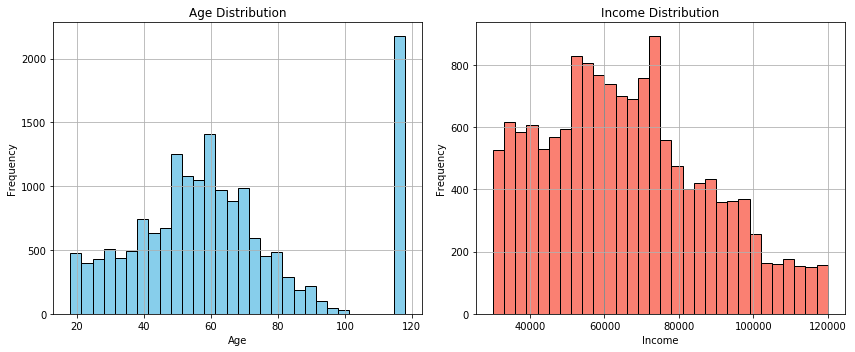

In [5]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot histogram for age
profile['age'].hist(ax=axes[0], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot histogram for income
profile['income'].hist(ax=axes[1], bins=30, color='salmon', edgecolor='black')
axes[1].set_title('Income Distribution')
axes[1].set_xlabel('Income')
axes[1].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

**It is noticeable that profile dataset have an outlier. The following code will check this further.**

In [6]:
# Check outlier in Age Column
profile[profile.age > 100].groupby(['age', 'gender'], as_index=False)['id'].count()


,age,gender,id
0,101,F,5


In [7]:
# Since there are NaN value in gender column, let's check age = 118 for both gender and income:
profile[profile.age == 118][['gender', 'income']]

,gender,income
0,None,NaN
2,None,NaN
4,None,NaN
6,None,NaN
7,None,NaN
9,None,NaN
10,None,NaN
11,None,NaN
17,None,NaN
23,None,NaN


In [8]:
# Check NA value for both gender and income:
print(profile[profile.age == 118]['gender'].isna().sum())
print(profile[profile.age == 118]['income'].isna().sum())

2175
2175


**It is clear that the age value is consistently 118 for all rows with missing values in the gender and income columns. Therefore, we can remove these rows to clean the data.**

### 1.3. Transactional Dataset:

In [9]:
# Check missing value
print(transcript.isnull().sum())

# Check number of persons by event
transcript.groupby('event')['person'].count()

event     0
person    0
time      0
value     0
dtype: int64


event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [10]:
''' 
We need to join between transaction and portfolio to check relevance between event and offer type.
I create join data frame following these codes.
'''
# First, expand value column in transcript
transcript_expand = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript_expand.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [11]:
# Merge offer id into one column
transcript_expand['offer_id_new'] = transcript_expand['offer id'].fillna(transcript_expand['offer_id'])

# Drop unnecessary offer_id & offer id columns
transcript_expand.drop(['offer id','offer_id'],axis=1,inplace=True)

# Rename to offer_id column
transcript_expand.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [12]:
# Join transcript with offer type
transcript_join=transcript_expand.merge(portfolio.rename(columns={'id':'offer_id'}),how='left', on='offer_id')

# Check relevance between event and offer type
transcript_join.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

Transaction data contains four types of events: offer completed, offer received, offer viewed, and transaction. However, transactions are not associated with any offer_id in the transcript event data, so I need to establish a method (based on the time-sequence of events) to assign each offer id to specific transaction.

##  2. Data Processing:

### 2.1. Assigning offer id to transactions

The steps below establish method to associate offer ids to individual transactions based on time-sequence of events as mentioning above. Then, main customer groups can be identified and categorized as following:

Group 1: People who are influenced by offers and successfully converted - "effective offers" including the chain of following transaction events:

- `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)
- `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within offer valid period)

Group 2: People who received and viewed an offer but did not successfully convert - "ineffective offers" including the chain of following transaction events:

- `offer received` -> `offer viewed`

Group 3: People who purchase/complete offers regardless of awareness of any offers - "unaware offers" including the chain of following transaction events:

- `transaction` (all)
- `offer received` -> `transaction` -> `offer completed` -> `offer viewed` (BOGO/discount offers)
- `transaction` -> `offer received` -> `offer completed` -> `offer viewed` (BOGO/discount offers)
- `offer received` -> `transaction` -> `offer viewed` -> `offer completed` (BOGO/discount offers)
- `offer received` -> `transaction` (informational offers)
- `offer received` -> `transaction` -> `offer viewed` (informational offers)

Group 4: People who received offers but did not view it nor take any action "no action":

- `offer received`


Separating different group, especially between the conversions for effective offers (group 1) and unaware offer (group 3) is challenging. 

To define the target variable "effective_offer", we can consider group 2 as ineffective offers and  deprioritize groups 3 and 4 from our model as they are less likely to respond to offers. 

The next step is to assign offer_ids to transactions. 

We can filter the transcript dataset by offer viewed and transaction events and use the pandas forward fill - `ffill()` method to fill each transaction with the offer id of the viewed offer, differentiate by their occurring before or after the transaction.

In [13]:
transcript_join.head()

,event,person,time,value,amount,reward_x,offer_id,channels,difficulty,duration,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo,10.0


In [14]:
# Fist, drop the useless columns
transcript_join.drop(['reward_x', 'reward_y'], axis=1, inplace=True)
transcript_join.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo


In [15]:
# Sort the dataset by person and time to view the order of events
transcript_join = transcript_join.sort_values(['person','time'], ascending =True)
transcript_join.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational


In [16]:
# Filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offer_completed = transcript_join[['time','offer_id','person','event']]\
    [(transcript_join['event']=='transaction') | (transcript_join['event']=='offer viewed')]

offer_completed.head()

,time,offer_id,person,event
77705,192,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,offer viewed
89291,228,NaN,0009655768c64bdeb2e877511632db8f,transaction
139992,372,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,offer viewed
168412,414,NaN,0009655768c64bdeb2e877511632db8f,transaction
187554,456,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,offer viewed


In [17]:
# Groups the DataFrame by the person column to be applied by the forward fill method
offer_completed.update(offer_completed.groupby(['person']).ffill())
# Apply forward fill method for offer_id
offer_completed['offer_id'] = offer_completed['offer_id'].ffill()

offer_completed.head()

,time,offer_id,person,event
77705,192,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,offer viewed
89291,228,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,transaction
139992,372,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,offer viewed
168412,414,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,transaction
187554,456,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,offer viewed


In [18]:
# Merge temporary dataset created above with transcript dataset to completely fill offer id into transaction.
transcript_processed = transcript_join.merge(offer_completed, how='left', on=['person','time','event'])
transcript_processed.head()

,event,person,time,value,amount,offer_id_x,channels,difficulty,duration,offer_type,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [19]:
# Combine offer_id columns and remove the dummy columns
transcript_processed['offer_id'] = np.where(transcript_processed['offer_id_x'].isnull(),\
                    transcript_processed['offer_id_y'], transcript_processed['offer_id_x'])

transcript_processed.drop(columns=['offer_id_x','offer_id_y'], axis=1, inplace=True)
transcript_processed.head()

,event,person,time,value,amount,channels,difficulty,duration,offer_type,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [20]:
# Merge the processed transcript with the portfolio dataset to retrieve offer data
transcript_processed = transcript_processed.merge(
    portfolio.rename(columns={'id': 'offer_id'}),
    how='left',
    on='offer_id'
)

# Combine duration columns, prioritizing duration_x over duration_y
transcript_processed['duration'] = transcript_processed['duration_x'].combine_first(transcript_processed['duration_y'])

# Drop unnecessary columns from the merged DataFrame
transcript_processed.drop(columns=['duration_x', 'offer_type_x', 'difficulty_x', 'channels_x', 'duration_y'], inplace=True)

# Rename remaining columns for clarity
transcript_processed.rename(columns={
    'channels_y': 'channels',
    'reward_y': 'reward',
    'difficulty_y': 'difficulty',
    'offer_type_y': 'offer_type'
}, inplace=True)

# quick check on processed dataset
transcript_processed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


### 2.2. Mark transactions and offers completed after offers viewed

The next crucial stage in preparing our data for modeling and analysis is to recognize a completed offer and transaction that follow an offer viewed.

As we have already filled in all transaction's offer ids, we can extract the transactions that converted from offers by checking if the offer viewed event happen before the transaction and offer completed (by matching the transaction's offer id and arrange these event in correct sequence of time).

To acheive this idea, I created a new column using pandas' `shift` function to label the sequence of events by offer id.


In [21]:
# Subset the dataset with only offer viewed, transaction, and offer completed events
transactions_after_viewed = transcript_processed[
    transcript_processed['event'].isin(['offer viewed', 'transaction', 'offer completed'])
].copy()

# Generate the previous offer id
transactions_after_viewed['pre_offer_id'] = transactions_after_viewed.groupby(['person', 'offer_id'])['offer_id'].shift()

# Create a flag for responded offers that were completed after the customer viewed the offer
transactions_after_viewed['completed_offer'] = np.where(
    transactions_after_viewed['pre_offer_id'] == transactions_after_viewed['offer_id'], 
    1, 
    0
)

# Quick check
transactions_after_viewed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,3f207df678b143eea3cee63160fa8bed,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0


In [22]:
# Join back the 'offer received' events which was filtered out in the previous step
offer_received = transcript_processed[transcript_processed['event'] == 'offer received'].copy()

# Since offer received events did not have pre offer id nor completed offer, I set these cols to nan
offer_received.loc[:, 'pre_offer_id'] = np.nan
offer_received.loc[:, 'completed_offer'] = np.nan

# Combine into transcript dataset
transcript_processed = pd.concat([offer_received, transactions_after_viewed]).sort_values(['person', 'time'])
transcript_processed.head()


,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0


Next, I separated the transcript data by offer type as different offers have different completion sequence. For example, an informational offer does not give rewards, while a discount or BOGO offer does.

In [23]:
# Split transcript dataset into 3 different offer types

bogo = transcript_processed[transcript_processed['offer_type']=='bogo'].copy()
discount = transcript_processed[transcript_processed['offer_type']=='discount'].copy()
informational = transcript_processed[transcript_processed['offer_type']=='informational'].copy()

print(bogo.head(2))
print(discount.head(2))
print(informational.head(2))

             event                            person  time  \
5   offer received  0009655768c64bdeb2e877511632db8f   408   
7  offer completed  0009655768c64bdeb2e877511632db8f   414   

                                               value  amount  \
5   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}     NaN   
7  {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...     NaN   

                           offer_id                      channels  difficulty  \
5  f19421c1d4aa40978ebb69ca19b0e20d  [web, email, mobile, social]           5   
7  f19421c1d4aa40978ebb69ca19b0e20d  [web, email, mobile, social]           5   

  offer_type  reward  duration pre_offer_id  completed_offer  
5       bogo       5       5.0          NaN              NaN  
7       bogo       5       5.0          NaN              0.0  
              event                            person  time  \
9    offer received  0009655768c64bdeb2e877511632db8f   504   
11  offer completed  0009655768c64bdeb2e877511632db8f   528  

After categorizing the transcript data by offer type, we can identify each unique combination of person and offer_id in group 1 using the `completed_offer` column. By marking all conversion events that occur after an offer viewed event, we can ensure that any conversion event with valid_completed=1 belongs to the first group of individuals who were influenced and successfully converted (effective offers).

For BOGO and discount offers, only "offer completed" events will be treated as conversion events. In contrast, for informational offers, transaction events will be considered as the conversion events. This distinction is critical because each offer type has unique criteria for completion. For instance, informational offers do not provide rewards, making their conversion criteria fundamentally different.

In [24]:
# Define a function to separate group 1 - effective offer - based on completed offer event
def get_completed_offers(offer_type_df):
    '''
    Takes in bogo & discount subsets to separate successful offer.

    inputs:
    - offer_type_df: subsets of transcript dataframe of specific offer types 

    outputs:
    - Returns dataframe containing event of "offer completed" with completed_offer flag.

    '''
    return (offer_type_df.loc[offer_type_df['completed_offer'] == 1]
            .loc[offer_type_df['event'] == 'offer completed']
            [['person', 'offer_id']]
            .groupby(['person', 'offer_id'])
            .count()
            .reset_index())

# Defining Group 1 people
bogo_completed = get_completed_offers(bogo)
discount_completed = get_completed_offers(discount)


For group 1, we are left with additional criterion for transactions to be effective offers - they need to occur within the offer's validity period. Therefore, we will define group 1 for informational offers later. Since it's safe to assume that every person who views an offer would have received the offer prior, we can separate group 2 and group 4 unique person-offer_ids for BOGO and discount offers by just taking the entire group of people who received an offer and subset them into group 2 and 4 for BOGO and discount offers.

In [25]:
# Define a function as we will repeat this for 2 datasets - BOGO & discount
def get_not_converted(offer_type_df):
    '''
    Takes in transcript subsets of single offer type to check for people of group 2 and group 4.

    inputs:
    - offer_type_df: original transcript dataframe of specific offer type 

    outputs:
    - Returns dataframe containing unique person-offer_id pairs with conversion events and offers received events, with indicator of each.
    '''
    # Subset offer id that have transactions or conversions by person and offer_id
    converted_ids = offer_type_df.loc[
        (offer_type_df['event'] == 'transaction') | (offer_type_df['event'] == 'offer completed'),
        ['person', 'offer_id']
    ].groupby(['person', 'offer_id']).count().reset_index()

    # Check for unique person-offer_id pairs that consist of offers received 
    offers_received = offer_type_df.loc[
        offer_type_df['event'] == 'offer received',
        ['person', 'offer_id']
    ].groupby(['person', 'offer_id']).count().reset_index()

    # Create merged dataset to differentiate groups
    check_merge = converted_ids.merge(offers_received, how='right', on=['person', 'offer_id'], indicator=True)
    return check_merge


check_merge_bogo = get_not_converted(bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())
print(check_merge_bogo.head())

check_merge_discount = get_not_converted(discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())
print(check_merge_discount.head())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
                             person                          offer_id _merge
0  0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d   both
1  00116118485d4dfda04fdbaba9a87b5c  f19421c1d4aa40978ebb69ca19b0e20d   both
2  0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   both
3  0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   both
4  0020ccbbb6d84e358d3414a3ff76cffd  9b98b8c7a33c4b65b9aebfe6a799e6d9   both
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901
                             person                          offer_id _merge
0  0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5   both
1  0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb4

Using `_merge` column with value right_only, we can separate group 2 and group 4 who only received offers but did not take further action to make transaction.

In [26]:
# Define function to extract group 2, 4 for both bogo and discount offer type
def extract_groups_2_4(offer_type_df, transcript_processed):
    '''
    Extracts groups 2 and 4 for a given offer type DataFrame.

    inputs:
    - offer_type_df: DataFrame containing offer events for a specific offer type (e.g., discount)
    - transcript_processed: DataFrame containing the processed transcript data

    outputs:
    - Returns two DataFrames: group_2 and group_4 for the specified offer type.
    '''
    # Identify group 2 and 4 entries
    group_2_4 = offer_type_df[offer_type_df['_merge'] == 'right_only']
    group_2_4 = group_2_4.merge(transcript_processed, how='left', on=['person', 'offer_id'])

    # Group 2: People who received and viewed an offer but did not convert
    group_2 = group_2_4[['person', 'offer_id']][group_2_4['event'] == 'offer viewed'].groupby(['person', 'offer_id']).count().reset_index()

    # Drop the '_merge' column
    group_2_4.drop(['_merge'], axis=1, inplace=True)

    # Group 4: People who received offers but did not view them nor take any action
    group_4 = group_2_4.merge(group_2[['person', 'offer_id']], how='left', indicator=True)
    group_4 = group_4[group_4['_merge'] == 'left_only'].copy()

    return group_2, group_4

# Now apply this function to the discount subset
group_2_bogo, group_4_bogo = extract_groups_2_4(check_merge_bogo, transcript_processed)
group_2_discount, group_4_discount = extract_groups_2_4(check_merge_discount, transcript_processed)


In [27]:
# Check the results
print('Group 2 for BOGO offers:')
print(group_2_bogo.head())

print('Group 4 for BOGO offers:')
print(group_4_bogo.head())

print('Group 2 for Discount offers:')
print(group_2_discount.head())

print('Group 4 for Discount offers:')
print(group_4_discount.head())

Group 2 for BOGO offers:
                             person                          offer_id
0  0063def0f9c14bc4805322a488839b32  9b98b8c7a33c4b65b9aebfe6a799e6d9
1  00857b24b13f4fe0ad17b605f00357f5  f19421c1d4aa40978ebb69ca19b0e20d
2  008d7088107b468893889da0ede0df5c  4d5c57ea9a6940dd891ad53e9dbe8da0
3  0092a132ead946ceb30d11a1ed513d20  9b98b8c7a33c4b65b9aebfe6a799e6d9
4  0092a132ead946ceb30d11a1ed513d20  ae264e3637204a6fb9bb56bc8210ddfd
Group 4 for BOGO offers:
                              person                          offer_id  \
0   0020c2b971eb4e9188eac86d93036a77  ae264e3637204a6fb9bb56bc8210ddfd   
3   00857b24b13f4fe0ad17b605f00357f5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
22  00bc983061d3471e8c8e74d31b7c8b6f  9b98b8c7a33c4b65b9aebfe6a799e6d9   
27  00e52682848542c3a6f59b7824e9a5c5  ae264e3637204a6fb9bb56bc8210ddfd   
30  00ed7e22b32749cfafbfd88592d401d4  ae264e3637204a6fb9bb56bc8210ddfd   

             event  time                                             value  \
0   off

Unaware group - group 3 consists of individuals who have transaction or offer completion events, but no preceding offer viewed events. In other words, this group includes unique person-offer_id pairs that completed an offer without viewing it beforehand. For BOGO and discount offers, group 3 specifically includes unique person-offer_id pairs with offer completion events where the completed_offer flag is not equal to 1.

In [28]:
# Find subset of the offer which has no connection with the offer
group3_bogo = bogo.loc[(bogo['event'] == 'offer completed') & (bogo['completed_offer'] != 1), ['person', 'offer_id']] \
                   .groupby(['person', 'offer_id']).count().reset_index()

group3_discount = discount.loc[(discount['event'] == 'offer completed') & (discount['completed_offer'] != 1), ['person', 'offer_id']] \
                         .groupby(['person', 'offer_id']).count().reset_index()

# Check the results
print('Group 3 for BOGO offers:')
print(group3_bogo.head())

print('Group 3 for Discount offers:')
print(group3_discount.head())


Group 3 for BOGO offers:
                             person                          offer_id
0  0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d
1  004c5799adbf42868b9cff0396190900  ae264e3637204a6fb9bb56bc8210ddfd
2  005500a7188546ff8a767329a2f7c76a  9b98b8c7a33c4b65b9aebfe6a799e6d9
3  00715b6e55c3431cb56ff7307eb19675  4d5c57ea9a6940dd891ad53e9dbe8da0
4  00715b6e55c3431cb56ff7307eb19675  ae264e3637204a6fb9bb56bc8210ddfd
Group 3 for Discount offers:
                             person                          offer_id
0  0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5
1  0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4
2  003d66b6608740288d6cc97a6903f4f0  0b1e1539f2cc45b7b9fa7c272da2e1d7
3  0056df74b63b4298809f0b375a304cf4  0b1e1539f2cc45b7b9fa7c272da2e1d7
4  0056df74b63b4298809f0b375a304cf4  2298d6c36e964ae4a3e7e9706d1fb8c2


In [29]:
# Final, let's assign flag to mark effective offer for group 1 & group 2 for both BOGO and discount
bogo_completed['effective_offer'] = 1
group_2_bogo['effective_offer'] = 0
offers_bogo = pd.concat([bogo_completed, group_2_bogo], sort=False)

discount_completed['effective_offer'] = 1
group_2_discount['effective_offer'] = 0
offers_discount = pd.concat([discount_completed, group_2_discount], sort=False)

# Check results
print(offers_bogo.head())
print(offers_discount.head())

                             person                          offer_id  \
0  0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
2  0020ccbbb6d84e358d3414a3ff76cffd  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3  0020ccbbb6d84e358d3414a3ff76cffd  f19421c1d4aa40978ebb69ca19b0e20d   
4  004b041fbfe44859945daa2c7f79ee64  f19421c1d4aa40978ebb69ca19b0e20d   

   effective_offer  
0                1  
1                1  
2                1  
3                1  
4                1  
                             person                          offer_id  \
0  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
1  0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   
2  0020c2b971eb4e9188eac86d93036a77  fafdcd668e3743c1bb461111dcafc2a4   
3  0020ccbbb6d84e358d3414a3ff76cffd  2298d6c36e964ae4a3e7e9706d1fb8c2   
4  003d66b6608740288d6cc97a6903f4f0  fafdcd668e3743c1bb461111dcafc2a4 

### 2.3. Check valid duration of informational offers to consider them as converted

Informational offers follow a different rule for determining an effective or converted transaction. Unlike other offer types, the conversion event for informational offers is a transaction rather than an offer completed event. An informational offer is considered effective only if the transaction occurs within the offer's validity period.

To align the time scales, the time data in the transcript, which is recorded in hours, must be converted to days, as the offer duration in the offers dataset is already expressed in days. This ensures consistency between the two datasets for accurate comparison.

In [30]:
# Check for missing values before processing
print(informational.isnull().sum())

event                  0
person                 0
time                   0
value                  0
amount             26066
offer_id               0
channels               0
difficulty             0
offer_type             0
reward                 0
duration               0
pre_offer_id       25368
completed_offer    15235
dtype: int64


In [31]:
# Convert time into days
informational.loc[:, 'day_offer'] = informational['time'] / 24

# Drop unnecessary columns
informational.drop(['time', 'value', 'pre_offer_id'], axis=1, inplace=True)

# Confirm the changes
print(informational.head())
print(informational.columns)

            event                            person  amount  \
0  offer received  0009655768c64bdeb2e877511632db8f     NaN   
1    offer viewed  0009655768c64bdeb2e877511632db8f     NaN   
2     transaction  0009655768c64bdeb2e877511632db8f   22.16   
3  offer received  0009655768c64bdeb2e877511632db8f     NaN   
4    offer viewed  0009655768c64bdeb2e877511632db8f     NaN   

                           offer_id                 channels  difficulty  \
0  5a8bc65990b245e5a138643cd4eb9837  [email, mobile, social]           0   
1  5a8bc65990b245e5a138643cd4eb9837  [email, mobile, social]           0   
2  5a8bc65990b245e5a138643cd4eb9837  [email, mobile, social]           0   
3  3f207df678b143eea3cee63160fa8bed     [web, email, mobile]           0   
4  3f207df678b143eea3cee63160fa8bed     [web, email, mobile]           0   

      offer_type  reward  duration  completed_offer  day_offer  
0  informational       0       3.0              NaN        7.0  
1  informational       0       3.0

In [32]:
# Sort transactions by person and offer
informational = informational.sort_values(['person', 'day_offer', 'event', 'offer_id'])

# Get difference in time for informational offers
informational['diff'] = informational.loc[
    (informational['offer_type'] == 'informational') & 
    ((informational['event'] == 'offer received') | (informational['event'] == 'transaction'))
].groupby(['person', 'offer_id'])['day_offer'].diff()

# Check results of change
print(informational[['person', 'offer_id', 'day_offer', 'diff']].head())


                             person                          offer_id  \
0  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
1  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
2  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
3  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   
4  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   

   day_offer  diff  
0        7.0   NaN  
1        8.0   NaN  
2        9.5   2.5  
3       14.0   NaN  
4       15.5   NaN  


In [33]:
# Create column to mark valid events
informational['valid_completed_duration'] = np.nan

# Flag valid events if within duration
informational.loc[informational['diff'] <= informational['duration'], 'valid_completed_duration'] = 1

# Fill any missing values with 0 flag
informational['valid_completed_duration'] = informational['valid_completed_duration'].fillna(value=0)

# Check results of change
print(informational[['person', 'offer_id', 'diff', 'duration', 'valid_completed_duration']].head())


                             person                          offer_id  diff  \
0  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   NaN   
1  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   NaN   
2  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   2.5   
3  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   NaN   
4  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   NaN   

   duration  valid_completed_duration  
0       3.0                       0.0  
1       3.0                       0.0  
2       3.0                       1.0  
3       4.0                       0.0  
4       4.0                       0.0  


In [34]:
# Flag effective offers that completed_offer = 1 and valid_completed_duration = 1
informational.loc[:, 'offer_responded'] = np.where(
    (informational['completed_offer'] == 1) & 
    (informational['valid_completed_duration'] == 1), 
    1, 
    0
)

# Confirm the changes
print(informational[['person', 'offer_id', 'completed_offer', 'valid_completed_duration', 'offer_responded']].head())


                             person                          offer_id  \
0  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
1  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
2  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
3  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   
4  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   

   completed_offer  valid_completed_duration  offer_responded  
0              NaN                       0.0                0  
1              0.0                       0.0                0  
2              1.0                       1.0                1  
3              NaN                       0.0                0  
4              0.0                       0.0                0  


Now, we separate group 1 for informational offers using above offer respond column, then split group 2 and 4 using the above get_not_converted

In [35]:
# Separate group 1 in transcript informational subset
informational_completed = informational.loc[informational['offer_responded'] == 1, ['person', 'offer_id']].groupby(['person', 'offer_id']).sum().reset_index()

# Confirm the changes
print(informational_completed.head())

                             person                          offer_id
0  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed
1  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837
2  0020c2b971eb4e9188eac86d93036a77  5a8bc65990b245e5a138643cd4eb9837
3  0020ccbbb6d84e358d3414a3ff76cffd  5a8bc65990b245e5a138643cd4eb9837
4  003d66b6608740288d6cc97a6903f4f0  3f207df678b143eea3cee63160fa8bed


In [36]:
# Separate out group 2 of customers
check_merge_info = get_not_converted(informational)

# Confirm the output of the not_converted function
print('Check the first few rows of check_merge_info:')
print(check_merge_info.head())

# Group and count occurrences in the _merge column
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).size())

Check the first few rows of check_merge_info:
                             person                          offer_id _merge
0  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   both
1  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   both
2  0011e0d4e6b944f998e987f904e8c1e5  3f207df678b143eea3cee63160fa8bed   both
3  0020c2b971eb4e9188eac86d93036a77  5a8bc65990b245e5a138643cd4eb9837   both
4  0020ccbbb6d84e358d3414a3ff76cffd  5a8bc65990b245e5a138643cd4eb9837   both
For informational offers:
_merge
left_only        0
right_only    5412
both          7239
dtype: int64


In [37]:
# Extract groups 2 and 4 for the informational offers
group_2_info, group_4_info = extract_groups_2_4(check_merge_info, transcript_processed)

# Check the results
print('Group 2 for Informational Offers:')
print(group_2_info.head())

print('Group 4 for Informational Offers:')
print(group_4_info.head())

Group 2 for Informational Offers:
                             person                          offer_id
0  0011e0d4e6b944f998e987f904e8c1e5  5a8bc65990b245e5a138643cd4eb9837
1  0063def0f9c14bc4805322a488839b32  5a8bc65990b245e5a138643cd4eb9837
2  008d7088107b468893889da0ede0df5c  5a8bc65990b245e5a138643cd4eb9837
3  00ae03011f9f49b8a4b3e6d416678b0b  5a8bc65990b245e5a138643cd4eb9837
4  00b18b535d6d4f779dea4dc9ac451478  5a8bc65990b245e5a138643cd4eb9837
Group 4 for Informational Offers:
                              person                          offer_id  \
2   004b041fbfe44859945daa2c7f79ee64  3f207df678b143eea3cee63160fa8bed   
5   0069a50874d846438e58acff5e594725  3f207df678b143eea3cee63160fa8bed   
6   00715b6e55c3431cb56ff7307eb19675  3f207df678b143eea3cee63160fa8bed   
15  00b3400e4ff64ee68ce9ada1d0c222f0  3f207df678b143eea3cee63160fa8bed   
16  00c91f31f5f74e769fa7a359b63e1a9f  3f207df678b143eea3cee63160fa8bed   

             event  time                                           

For group 3 identification for informational offers, we consider 2 cases as mentioned above: transactions happened before offer viewed ('completed_offer' != 1) or duration between transaction and offer received events was not within valid offer duration (valid_completed_duration' != 1).

In [38]:
# Case 1: transactions happened before offer viewed
group3_1 = informational[['person', 'offer_id']][
    (informational['event'] == 'transaction') & 
    (informational['completed_offer'] != 1) & 
    (informational['valid_completed_duration'] == 1)
].groupby(['person', 'offer_id']).count().reset_index()

# Case 2: duration between transaction and offer received events was not within valid offer duration
group3_2 = informational[['person', 'offer_id']][
    (informational['event'] == 'transaction') & 
    (informational['completed_offer'] == 1) & 
    (informational['valid_completed_duration'] != 1)
].groupby(['person', 'offer_id']).count().reset_index()

# Combine both groups
group_3_info = pd.concat([group3_1, group3_2], sort=False)

# Clean up temporary variables
del group3_1
del group3_2


In [39]:
# Create offers_info using the final_offers_dataset function
informational_completed['effective_offer'] = 1
group_2_info['effective_offer'] = 0
offers_info = pd.concat([informational_completed, group_2_info], sort=False)

# Confirm the changes
print(offers_info.head())

                             person                          offer_id  \
0  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   
1  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
2  0020c2b971eb4e9188eac86d93036a77  5a8bc65990b245e5a138643cd4eb9837   
3  0020ccbbb6d84e358d3414a3ff76cffd  5a8bc65990b245e5a138643cd4eb9837   
4  003d66b6608740288d6cc97a6903f4f0  3f207df678b143eea3cee63160fa8bed   

   effective_offer  
0                1  
1                1  
2                1  
3                1  
4                1  


### 2.4. Feature Engineering:

#### a. Using became_member_on column for membership tenure feature
We can transform the became_member_on feature into a new variable representing the duration of membership. This adjustment may influence the model's ability to predict whether a customer is likely to accept an offer.

In [40]:
# Rename 'id' to 'person' in the profile DataFrame
profile.rename(columns={'id': 'person'}, inplace=True)
print(profile.columns)

# Create a function to generate the length of time since the user became a member
def member_since(df):
    '''
    Inputs:
    - df: DataFrame to generate the length of time since the user became a member
    Outputs:
    - Returns DataFrame with the 'became_member_on' column transformed to be tenure in days
    '''
    # Merge to get user demographic profile
    df = df.merge(profile[['person', 'became_member_on', 'gender', 'age', 'income']], how='left', on='person')
    
    # Convert 'became_member_on' into member tenure
    df['became_member_on'] = df['became_member_on'].astype(str)  # Ensure it's a string for slicing
    df['year'] = df['became_member_on'].str[:4].astype(int)
    df['month'] = df['became_member_on'].str[4:6].astype(int)
    df['day'] = df['became_member_on'].str[6:8].astype(int)
    
    # Drop the 'became_member_on' column
    df.drop('became_member_on', axis=1, inplace=True)

    # Calculate membership days
    df['membership_days'] = (2018 - df['year']) * 365 + (df['month'] - 1) * 30 + df['day']
    
    # Handle cases where the year is 2018
    df.loc[df['year'] == 2018, 'membership_days'] = (df['month'] - 1) * 30 + df['day']

    # Drop the temporary columns
    df.drop(['year', 'month', 'day'], axis=1, inplace=True)
    
    return df

# Apply the function to the offers DataFrames
offers_bogo = member_since(offers_bogo)
offers_discount = member_since(offers_discount)
offers_info = member_since(offers_info)

print(offers_bogo.head())
print(offers_discount.head())
print(offers_info.head())

Index(['age', 'became_member_on', 'gender', 'person', 'income'], dtype='object')
                             person                          offer_id  \
0  0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
2  0020ccbbb6d84e358d3414a3ff76cffd  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3  0020ccbbb6d84e358d3414a3ff76cffd  f19421c1d4aa40978ebb69ca19b0e20d   
4  004b041fbfe44859945daa2c7f79ee64  f19421c1d4aa40978ebb69ca19b0e20d   

   effective_offer gender  age   income  membership_days  
0                1      O   40  57000.0                9  
1                1      F   59  90000.0              794  
2                1      F   24  60000.0             1041  
3                1      F   24  60000.0             1041  
4                1      F   55  74000.0              128  
                             person                          offer_id  \
0  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7

#### b. Multiple offers received by person

An observation based on data exploration shows that a person could receive multiple offers. The number of times a particular offer is received by a customer could also have an impact on whether the offer is effective or not.

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


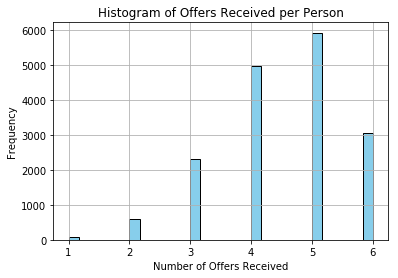

In [41]:
# Group event = 'offer received' per person in transactional records
offers_received_count = transcript_processed[transcript_processed['event'] == 'offer received'].groupby('person')['event'].count()

# Print the first few records of offers received per person
print(offers_received_count.head())

# Visualize offers received per person
offers_received_count.hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Offers Received per Person')
plt.xlabel('Number of Offers Received')
plt.ylabel('Frequency')
plt.show()


Since the number of offers mostly fell into the range of 3-6 offer per person, I hypothesized that receiving offers more frequently might result in more effective offers. To evaluate this, I introduced a new feature called "offer_received_cnt," which represents the frequency of offers received by each individual.

In [42]:
# Get count of offers received per person, put into a separate dataset
df_offer_received_cnt = (
    transcript_processed[transcript_processed['event'] == 'offer received']
    .groupby(['person', 'offer_id', 'time'])
    .count()['event']
    .reset_index()
)

# Rename columns
df_offer_received_cnt.rename(columns={'event': 'offer_received_cnt'}, inplace=True)

# Drop redundant columns
df_offer_received_cnt.drop(['time'], axis=1, inplace=True)

# Ensure only unique person-offer_id pairs
df_offer_received_cnt = df_offer_received_cnt.groupby(['person', 'offer_id']).sum().reset_index()

# Check results of changes
print(df_offer_received_cnt.head())


                             person                          offer_id  \
0  0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5   
1  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   
2  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
3  0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d   
4  0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4   

   offer_received_cnt  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  


#### 3. Remove transactions which was not related to the offer

Some transactions were unrelated to offers and considered 'invalid', primarily from users in groups 3 and 4, who purchased regardless of offers. For group 1, high 'invalid spend' outside offers could indicate predictive power for offer effectiveness, as these loyal users might be more likely to take up offers. To identify such transactions, I separated conversions from normal purchases using the `completed_offer` column, checking if a transaction followed an offer viewed event. Transactions with `offer_completed=1` were flagged as effective for BOGO and Discount offers, while those with `offer_completed=0` were excluded. Including the baseline of 'invalid transactions' as a feature helped predict user propensity to accept offers and measure their effectiveness.

In [43]:
# Filter dataset by invalid transactions
# Subtract the transactions which are not related to the offer
transactions_not_related = (
    transcript_processed[(transcript_processed['event'] == 'transaction') & 
                        (transcript_processed['completed_offer'] == 0)]
    .groupby(['person', 'offer_id'])['amount']
    .sum()
    .reset_index()
)

# Rename the 'amount' column to 'amount_invalid'
transactions_not_related.rename(columns={'amount': 'amount_invalid'}, inplace=True)

# Check the some invalid transactions
print(transactions_not_related.head())


                             person                          offer_id  \
0  0020ccbbb6d84e358d3414a3ff76cffd  5a8bc65990b245e5a138643cd4eb9837   
1  004b041fbfe44859945daa2c7f79ee64  fafdcd668e3743c1bb461111dcafc2a4   
2  0063def0f9c14bc4805322a488839b32  2298d6c36e964ae4a3e7e9706d1fb8c2   
3  0069a50874d846438e58acff5e594725  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4  00715b6e55c3431cb56ff7307eb19675  2906b810c7d4411798c6938adc9daaa5   

   amount_invalid  
0           16.27  
1           25.62  
2            2.76  
3           16.20  
4           27.26  


## 3. Prepare Data for Model Implementation

### 3.1. Combine (merge) the feature engineering datasets with the main dataset.

In [44]:
# Merge to get offers received count into offers_bogo
offers_bogo = offers_bogo.merge(
    df_offer_received_cnt[['person', 'offer_id', 'offer_received_cnt']],
    how='left',
    on=['person', 'offer_id']
)

# Merge to get invalid amount transacted into offers_bogo
offers_bogo = offers_bogo.merge(
    transactions_not_related[['person', 'offer_id', 'amount_invalid']],
    how='left',
    on=['person', 'offer_id']
)

# Confirm the changes
print(offers_bogo.head())
print(offers_bogo.isnull().sum())
print(offers_bogo.info())


                             person                          offer_id  \
0  0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
2  0020ccbbb6d84e358d3414a3ff76cffd  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3  0020ccbbb6d84e358d3414a3ff76cffd  f19421c1d4aa40978ebb69ca19b0e20d   
4  004b041fbfe44859945daa2c7f79ee64  f19421c1d4aa40978ebb69ca19b0e20d   

   effective_offer gender  age   income  membership_days  offer_received_cnt  \
0                1      O   40  57000.0                9                   1   
1                1      F   59  90000.0              794                   1   
2                1      F   24  60000.0             1041                   1   
3                1      F   24  60000.0             1041                   1   
4                1      F   55  74000.0              128                   1   

   amount_invalid  
0             NaN  
1             NaN  
2             NaN  


### 3.2. Cleanse Demographic data by dropping missing values in gender column

amount_invalid        96.323752
income                 7.057489
gender                 7.057489
offer_received_cnt     0.000000
membership_days        0.000000
dtype: float64


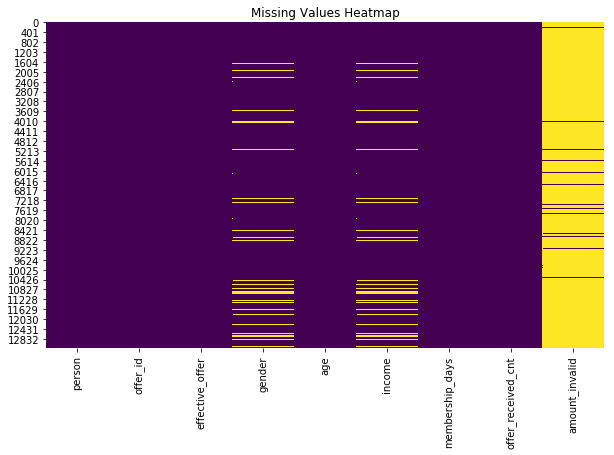

In [45]:
# Check percentage of missing values in the dataset
missing_percentage = (offers_bogo.isnull().sum() / len(offers_bogo) * 100).sort_values(ascending=False)

# Display the top columns with the highest percentage of missing values
print(missing_percentage.head())

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(offers_bogo.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


amount_invalid column has a significant proportion of missing data (97%) and may offer limited value for BOGO offers. While we may revisit this feature during the model implementation phase, we will temporarily fill its missing values with 0. Additionally, the income and gender columns are dropped due to their lack of usefulness when containing missing data.

In [46]:
# Fill missing values for amount_invalid with 0
offers_bogo['amount_invalid'] = offers_bogo['amount_invalid'].fillna(value=0)

# Drop any remaining rows with missing values
offers_bogo.dropna(inplace=True)

# Check the changes
print(offers_bogo.isnull().sum())
print(offers_bogo.info())


person                0
offer_id              0
effective_offer       0
gender                0
age                   0
income                0
membership_days       0
offer_received_cnt    0
amount_invalid        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12287 entries, 0 to 13219
Data columns (total 9 columns):
person                12287 non-null object
offer_id              12287 non-null object
effective_offer       12287 non-null int64
gender                12287 non-null object
age                   12287 non-null int64
income                12287 non-null float64
membership_days       12287 non-null int64
offer_received_cnt    12287 non-null int64
amount_invalid        12287 non-null float64
dtypes: float64(2), int64(4), object(3)
memory usage: 959.9+ KB
None


### 3.3. Split channel column into categorical variables

In [47]:
# Merge with portfolio to get offer details
offers_bogo = offers_bogo.merge(portfolio.rename(columns={'id':'offer_id'}), how='left', on='offer_id')
offers_info = offers_info.merge(portfolio.rename(columns={'id':'offer_id'}), how='left', on='offer_id')

# Reset index
offers_bogo = offers_bogo.reset_index().drop(['index'],axis=1,inplace=False)
offers_info = offers_info.reset_index().drop(['index'],axis=1,inplace=False)

# Convert channels into categorical variables
def convert_channels_to_categorical(df):
    """
    Convert the 'channels' column in the DataFrame into categorical variables.
    
    Parameters:
    df (DataFrame): The DataFrame containing the 'channels' column.
    
    Returns:
    DataFrame: The updated DataFrame with individual channel columns.
    """
    # Create new columns for each channel and initialize them to 0
    for channel in ['web', 'email', 'social', 'mobile']:
        df[channel] = 0  # Initialize all channels to 0

    # Set the channel value to 1 if the channel is present in the 'channels' column
    for index, row in df.iterrows():
        for channel in ['web', 'email', 'social', 'mobile']:
            if channel in row['channels']:
                df.at[index, channel] = 1

    # Drop the original 'channels' column
    df = df.drop(['channels'], axis=1, inplace=False)
    
    return df

# Apply the function to offers_info and offers_bogo
offers_info = convert_channels_to_categorical(offers_info)
offers_bogo = convert_channels_to_categorical(offers_bogo)

# Check the results
print(offers_info.head())
print(offers_bogo.head())      

# Check results
print(offers_bogo.head())


                             person                          offer_id  \
0  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   
1  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
2  0020c2b971eb4e9188eac86d93036a77  5a8bc65990b245e5a138643cd4eb9837   
3  0020ccbbb6d84e358d3414a3ff76cffd  5a8bc65990b245e5a138643cd4eb9837   
4  003d66b6608740288d6cc97a6903f4f0  3f207df678b143eea3cee63160fa8bed   

   effective_offer gender  age   income  membership_days  difficulty  \
0                1      M   33  72000.0              476           0   
1                1      M   33  72000.0              476           0   
2                1      F   59  90000.0              794           0   
3                1      F   24  60000.0             1041           0   
4                1      F   26  73000.0              536           0   

   duration     offer_type  reward  web  email  social  mobile  
0         4  informational       0    1      1       0       1 

In [48]:
# Create function to reuse dummy variable split function
def dummy(df, col):
    """Create dummy variables for a specified column in the DataFrame."""
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    df.drop(columns=[col], axis=1, inplace=True)
    return df


# Check if 'gender' column exists in offers_bogo
if 'gender' in offers_bogo.columns:
    # Convert gender into categorical variables using the dummy function
    offers_bogo = dummy(offers_bogo, 'gender')
else:
    print("The 'gender' column does not exist in the offers_bogo DataFrame.")

# Check changes
print(offers_bogo.info())
offers_bogo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12287 entries, 0 to 12286
Data columns (total 19 columns):
person                12287 non-null object
offer_id              12287 non-null object
effective_offer       12287 non-null int64
age                   12287 non-null int64
income                12287 non-null float64
membership_days       12287 non-null int64
offer_received_cnt    12287 non-null int64
amount_invalid        12287 non-null float64
difficulty            12287 non-null int64
duration              12287 non-null int64
offer_type            12287 non-null object
reward                12287 non-null int64
web                   12287 non-null int64
email                 12287 non-null int64
social                12287 non-null int64
mobile                12287 non-null int64
gender_F              12287 non-null uint8
gender_M              12287 non-null uint8
gender_O              12287 non-null uint8
dtypes: float64(2), int64(11), object(3), uint8(3)
memory usage: 1.

,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,9,1,0.0,5,7,bogo,5,1,1,0,1,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,794,1,0.0,10,5,bogo,10,1,1,1,1,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,1041,1,0.0,5,7,bogo,5,1,1,0,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,1041,1,0.0,5,5,bogo,5,1,1,1,1,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,128,1,0.0,5,5,bogo,5,1,1,1,1,1,0,0


In [49]:
# Merge with portfolio to get offer details
offers_discount = offers_discount.merge(portfolio.rename(columns={'id':'offer_id'}), how='left', on='offer_id')

# Reset index
offers_discount = offers_discount.reset_index().drop(['index'],axis=1,inplace=False)

# Create function to include engineering feature for processing discount & info offers df (same as bogo)
def feat_engineering_prep(df):
    '''
    Prepares the offers DataFrame by merging engineered features, filling missing values, 
    and transforming the gender column into dummy variables.
    
    inputs:
    - df: DataFrame to be transformed 
    
    outputs:
    - Returns DataFrame with engineered features and filled missing values, with transformed gender column.
    '''

    # Merge to get engineered features 
    df = df.merge(df_offer_received_cnt[['person', 'offer_id', 'offer_received_cnt']], how='left', on=['person', 'offer_id'])
    df = df.merge(transactions_not_related[['person', 'offer_id', 'amount_invalid']], how='left', on=['person', 'offer_id'])

    # Fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid'] = df['amount_invalid'].fillna(value=0)
    df['offer_received_cnt'] = df['offer_received_cnt'].fillna(value=0)

     # Check for columns to drop and print messages if they do not exist
    columns_to_check = ['gender', 'income', 'age']
    for col in columns_to_check:
        if col not in df.columns:
            print(f"Column '{col}' does not exist in the DataFrame.")
        else:
            # Drop rows with null values for existing columns
            df.dropna(subset=[col], inplace=True)


    # Convert gender column into dummy variables
    df = dummy(df, 'gender')
    
    # Optional: Return a summary of the DataFrame
    print(f"Processed DataFrame shape: {df.shape}")
    print(df.head())
    
    return df

# Apply convert_channels_to_categorical to discount and feat_engineering_prep to discount and infomational
offers_discount = convert_channels_to_categorical(offers_discount)

In [50]:
# Check results
print(offers_discount.info())
offers_discount.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13899 entries, 0 to 13898
Data columns (total 15 columns):
person             13899 non-null object
offer_id           13899 non-null object
effective_offer    13899 non-null int64
gender             12724 non-null object
age                13899 non-null int64
income             12724 non-null float64
membership_days    13899 non-null int64
difficulty         13899 non-null int64
duration           13899 non-null int64
offer_type         13899 non-null object
reward             13899 non-null int64
web                13899 non-null int64
email              13899 non-null int64
social             13899 non-null int64
mobile             13899 non-null int64
dtypes: float64(1), int64(10), object(4)
memory usage: 1.6+ MB
None


,person,offer_id,effective_offer,gender,age,income,membership_days,difficulty,duration,offer_type,reward,web,email,social,mobile
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,O,40,57000.0,9,20,10,discount,5,1,1,0,0
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,O,40,57000.0,9,7,7,discount,3,1,1,1,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,F,59,90000.0,794,10,10,discount,2,1,1,1,1
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,F,24,60000.0,1041,7,7,discount,3,1,1,1,1
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,F,26,73000.0,536,10,10,discount,2,1,1,1,1


In [51]:
# Apply feat_engineering_prep to discount and infomational
offers_info = feat_engineering_prep(offers_info)
offers_discount = feat_engineering_prep(offers_discount)

# Check offer discount
offers_discount.head()

Processed DataFrame shape: (7225, 19)
                             person                          offer_id  \
0  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   
1  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
2  0020c2b971eb4e9188eac86d93036a77  5a8bc65990b245e5a138643cd4eb9837   
3  0020ccbbb6d84e358d3414a3ff76cffd  5a8bc65990b245e5a138643cd4eb9837   
4  003d66b6608740288d6cc97a6903f4f0  3f207df678b143eea3cee63160fa8bed   

   effective_offer  age   income  membership_days  difficulty  duration  \
0                1   33  72000.0              476           0         4   
1                1   33  72000.0              476           0         3   
2                1   59  90000.0              794           0         3   
3                1   24  60000.0             1041           0         3   
4                1   26  73000.0              536           0         4   

      offer_type  reward  web  email  social  mobile  offer_received_cnt

,person,offer_id,effective_offer,age,income,membership_days,difficulty,duration,offer_type,reward,web,email,social,mobile,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,9,20,10,discount,5,1,1,0,0,1,0.0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,9,7,7,discount,3,1,1,1,1,1,0.0,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,794,10,10,discount,2,1,1,1,1,2,0.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,1041,7,7,discount,3,1,1,1,1,1,0.0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,536,10,10,discount,2,1,1,1,1,2,0.0,1,0,0


In [52]:
# Sort column order following bogo
offers_discount = offers_discount[offers_bogo.columns]
offers_info = offers_info[offers_bogo.columns]

# Check offer discount
offers_discount.head()

,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,9,1,0.0,20,10,discount,5,1,1,0,0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,9,1,0.0,7,7,discount,3,1,1,1,1,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,794,2,0.0,10,10,discount,2,1,1,1,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,1041,1,0.0,7,7,discount,3,1,1,1,1,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,536,2,0.0,10,10,discount,2,1,1,1,1,1,0,0


In [53]:
# Check offer info
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,social,mobile,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,476,1.0,0.00,0,4,informational,0,1,1,0,1,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,476,1.0,0.00,0,3,informational,0,0,1,1,1,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,794,1.0,0.00,0,3,informational,0,0,1,1,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,1041,1.0,16.27,0,3,informational,0,0,1,1,1,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,536,1.0,0.00,0,4,informational,0,1,1,0,1,1,0,0


## 4. Model Implementation

Since there are three offer types, three separate binary classification supervised learning models need to be built. Tree-based models were chosen to ensure interpretability of the model since the project aims to predict whether the customer will respond to the different types of offers or not. Random Forest was selected as an alternate model to compare with the baseline model. Before proceeding with model implementation, class balance in each dataset needs to be ensured.

It is crucial to evaluate and validate the models using both accuracy and F1 score, given the presence of imbalanced classes. The F1 score is a more suitable metric as it accounts for both false positives and false negatives, making it particularly useful for datasets with uneven class distribution. Emphasizing the F1 score is appropriate for this Starbucks app since the primary focus is on determining whether offers are effective, rather than analyzing the specific reasons for their ineffectiveness.

### 4.1. Implement model preparation, train and run

In [54]:
# Define target and feature variables to predict offer effectiveness

def model_prep(df, cols_dropped):
    '''
    Prepares the data for modeling by separating features and the target variable.

    inputs:
    - df: DataFrame containing the data for modeling, must include 'effective_offer' column.
    - cols_dropped: list of columns to be dropped from the features.

    outputs:
    - features: DataFrame containing the feature variables.
    - target: Series containing the target variable (effective_offer).
    '''
    # Check if columns to drop exist in the DataFrame
    for col in cols_dropped:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame.")

    # Split the data into features and target label
    features = df.drop(columns=cols_dropped)
    target = df['effective_offer']
    
    return features, target


In [55]:
# Define function to split training set and a test set. Apply a scaler to standardize the data before training

def model_split_scaler(features, target):
    '''
    inputs:
    - features: containing the features generated from model_prep function
    - target: containing the target generated from model_prep function
    
    outputs:
    - X_train, X_test: containing the training & testing features based on split function
    - Y_train: containing the training target to fit into model
    - Y_test: containing the testing target to be compared with prediction
    
    '''
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=44)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, Y_train, Y_test


In [56]:
# Define function to train, test model and create report

def model_train_predict(model, X_train, Y_train, X_test, Y_test):
    '''
    inputs:
    - model: the learning algorithm to be trained and predicted on
    - X_train: features training set
    - y_train: target variable training set
    - X_test: features testing set
    - y_test: target variable testing set

    outputs:
    - Prints training time, testing time, mean squared error, training accuracy, testing accuracy, and classification report. Returns dictionary of results.
    '''
    # Define results dictionary
    results = {}

    # Fit the model to the training data and get training time
    start = time()
    model.fit(X_train, Y_train)
    end = time()
    results['train_time'] = end - start

    # Predict based on the test set, and get predicting time
    start = time()
    predict_test_set = model.predict(X_test)
    predict_train_set = model.predict(X_train)
    end = time()

    # Calculate the prediction time
    results['predict_time'] = end - start

    # Add training accuracy to results
    results['training_score'] = model.score(X_train, Y_train)

    # Add testing accuracy to results
    results['testing_score'] = model.score(X_test, Y_test)
    
    # Add F1 score for the test set
    results['f1_score'] = f1_score(Y_test, predict_test_set, average='weighted')

    print(f"{model.__class__.__name__} trained on {len(Y_train)} samples.")
    print(f"MSE for train set: {mean_squared_error(Y_train, predict_train_set):.4f}")
    print(f"MSE for test set: {mean_squared_error(Y_test, predict_test_set):.4f}")
    print(f"Train accuracy: {results['training_score']:.4f}")
    print(f"Test accuracy: {results['testing_score']:.4f}")
    print(classification_report(Y_test, predict_test_set, digits=4))

    return results


In [57]:
# Run 2 classification model to compair

def model_pipeline_run(classify_1, classify_2, name):
    '''
    inputs:
    - classify_1: first classifier model
    - classify_2: second classifier model for comparison
    - name: name of models for comparison

    outputs:
    - Results from model training and predicting (covert dictionary to dataframe)
    
    '''
    
    # Collect results on the learners
    results = {}
    
    for cl in [classify_1, classify_2]:
        classify_name = cl.__class__.__name__ + '_' + name
        results[classify_name] = {}
        results[classify_name] = model_train_predict(cl, X_train, Y_train, X_test, Y_test)
    results = pd.DataFrame(results)
    return pd.DataFrame(results)


#### a. Apply to BOGO offers dataset

In [58]:
# Create list column to be dropped as unnecessary features
offers_cols_dropped = ['person','offer_id','effective_offer','offer_type']

In [59]:
# Prepare features, target set and split
features, target = model_prep(offers_bogo, offers_cols_dropped)
X_train, X_test, Y_train, Y_test = model_split_scaler(features, target)

# Initialize the baseline model (Decision Tree)
baseline = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                                  random_state=2, min_samples_split=70, 
                                  min_samples_leaf=30)

# Initialize the model
bogo_r1 = RandomForestClassifier(random_state=2, max_depth=5, 
                                    max_features='auto', min_samples_split=5, 
                                    n_estimators=10, min_samples_leaf=5)

# Initiate results dataframe for the first run
results_df = pd.DataFrame()

# Run the model and concatenate 1st result of bogo_r1
results_df = pd.concat([results_df, model_pipeline_run(baseline, bogo_r1, 'bogo_r1')], axis=1)


DecisionTreeClassifier trained on 9829 samples.
MSE for train set: 0.1709
MSE for test set: 0.1794
Train accuracy: 0.8291
Test accuracy: 0.8206
             precision    recall  f1-score   support

          0     0.4670    0.2488    0.3247       426
          1     0.8566    0.9405    0.8966      2032

avg / total     0.7890    0.8206    0.7974      2458

RandomForestClassifier trained on 9829 samples.
MSE for train set: 0.1790
MSE for test set: 0.1733
Train accuracy: 0.8210
Test accuracy: 0.8267
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       426
          1     0.8267    1.0000    0.9051      2032

avg / total     0.6834    0.8267    0.7483      2458



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Both models achieved an accuracy of approximately 82%, with the Random Forest model slightly surpassing the Decision Tree Classifier. However, F1 scores for both models were below 80%, with the Random Forest model showing better performance in minimizing the misclassification of false positive events. Given the goal of avoiding missed opportunities for effective offers, the Random Forest model was chosen. Feature importance analysis will follow after further model refinement.

#### b. Apply to discount offers dataset

In [60]:
# Prepare features, target set and split for discount
features, target = model_prep(offers_discount, offers_cols_dropped)
X_train, X_test, Y_train, Y_test = model_split_scaler(features, target)

# Initialize the baseline model (Decision Tree)
baseline = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                                  random_state=2, min_samples_split=70, 
                                  min_samples_leaf=30)

# Initialize the model
discount_r1 = RandomForestClassifier(random_state=2, max_depth=5, 
                                    max_features='auto', min_samples_split=5, 
                                    n_estimators=10, min_samples_leaf=5)

# Run the model and concatenate results
results_df = pd.concat([results_df[:], 
                     model_pipeline_run(baseline, discount_r1, 'discount_r1')], axis=1)


DecisionTreeClassifier trained on 10179 samples.
MSE for train set: 0.1359
MSE for test set: 0.1328
Train accuracy: 0.8641
Test accuracy: 0.8672
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       338
          1     0.8672    1.0000    0.9289      2207

avg / total     0.7520    0.8672    0.8055      2545

RandomForestClassifier trained on 10179 samples.
MSE for train set: 0.1359
MSE for test set: 0.1328
Train accuracy: 0.8641
Test accuracy: 0.8672
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       338
          1     0.8672    1.0000    0.9289      2207

avg / total     0.7520    0.8672    0.8055      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Random Forest Classifier model also has same performance compared to the Decision Tree Classifier in terms of accuracy (86.72%), and the F1 score (80.55%).

#### c. Apply to info offers dataset

In [61]:
# Prepare features, target set and split for informational
features, target = model_prep(offers_info, offers_cols_dropped)
X_train, X_test, Y_train, Y_test = model_split_scaler(features, target)

# Initialize the baseline model (Decision Tree)
baseline = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                                  random_state=2, min_samples_split=70, 
                                  min_samples_leaf=30)

# Initialize the model
informational_r1 = RandomForestClassifier(random_state=2, max_depth=5, 
                                    max_features='auto', min_samples_split=5, 
                                    n_estimators=10, min_samples_leaf=5)

# Run the model and concatenate results
results_df = pd.concat([results_df[:], 
                     model_pipeline_run(baseline, informational_r1, 'informational_r1')], 
                    axis=1)


DecisionTreeClassifier trained on 5780 samples.
MSE for train set: 0.2405
MSE for test set: 0.2346
Train accuracy: 0.7595
Test accuracy: 0.7654
             precision    recall  f1-score   support

          0     0.6429    0.1253    0.2098       359
          1     0.7716    0.9770    0.8623      1086

avg / total     0.7396    0.7654    0.7002      1445

RandomForestClassifier trained on 5780 samples.
MSE for train set: 0.2483
MSE for test set: 0.2429
Train accuracy: 0.7517
Test accuracy: 0.7571
             precision    recall  f1-score   support

          0     0.7500    0.0334    0.0640       359
          1     0.7572    0.9963    0.8604      1086

avg / total     0.7554    0.7571    0.6626      1445



Both models achieved quite a low accuracy (under 80%), with the Random Forest model slightly doing worse than the Decision Tree Classifier. F1 scores for both models were also below 71%, which initiate needs of further model refinement. The worse performance could be due to the assumption made to assign the conversion events only to transactions that occur after an offer is viewed and within the specified duration. This assumption may have resulted in the removal of valuable factors.

### 4.2. Refine model

Grid Search was used on all three offers to find the best parameters for Random Forest Classifier model.

In [62]:
# Define Grid Search function

def grid_search(X, Y):
    '''
    inputs:
    - X: features training set
    - Y: target training set
    
    output:
    - dictionary with best hyperparameters for the random forest classifier
    
    '''
    # Initialize grid of parameter
    param = {
        'max_features': ['auto', 'sqrt'],
        'max_depth': [5, 10, 15, 20],
        'n_estimators': [10, 20, 35, 50],
        'min_samples_split': [5, 10, 20, 30],
        'min_samples_leaf': [5, 10, 15, 20]
    }
    
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param)
    grid_search.fit(X, Y)
    
    return grid_search.best_params_

In [63]:
# Define best model selection function

def model_best_params(offer_type):
    '''
    Identifies the best Random Forest model for a given offer type.

    Input:
    - offer_type: string representing the name of the offer type.

    Output:
    - containing the results of the best model for the specified offer type.
    '''
    # Print a message indicating the model being evaluated
    print(f"For {offer_type}, the best Random Forest model:")

    # Transpose the results DataFrame for easier querying
    transposed_results = results_df.transpose()

    # Filter for Random Forest models specific to the offer type
    rf_models = transposed_results[transposed_results.index.str.contains(f"RandomForestClassifier_{offer_type}")]

    # Find the row corresponding to the highest testing score and F1 score
    best_rf_model = rf_models[
        (rf_models['testing_score'] == rf_models['testing_score'].max()) &
        (rf_models['f1_score'] == rf_models['f1_score'].max())
    ]

    return best_rf_model


Now apply the grid search to find best parameters for each of 3 offer types

In [64]:
# BOGO dataset
features,target = model_prep(offers_bogo, offers_cols_dropped)
X_train, X_test, Y_train, Y_test = model_split_scaler(features, target)

# Run Grid Search 
grid_search(X_train, Y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 50}

In [65]:
# Initialize the model using selected parameters by grid search
bogo_r2 = RandomForestClassifier(random_state=2,max_depth= 10, 
                                 max_features= 'auto',min_samples_split= 20,
                                 n_estimators=50,min_samples_leaf=5)

results_df = pd.concat([results_df[:],model_pipeline_run(baseline,bogo_r2,'bogo_r2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE for train set: 0.1709
MSE for test set: 0.1794
Train accuracy: 0.8291
Test accuracy: 0.8206
             precision    recall  f1-score   support

          0     0.4670    0.2488    0.3247       426
          1     0.8566    0.9405    0.8966      2032

avg / total     0.7890    0.8206    0.7974      2458

RandomForestClassifier trained on 9829 samples.
MSE for train set: 0.1542
MSE for test set: 0.1705
Train accuracy: 0.8458
Test accuracy: 0.8295
             precision    recall  f1-score   support

          0     0.5315    0.1385    0.2197       426
          1     0.8436    0.9744    0.9043      2032

avg / total     0.7895    0.8295    0.7857      2458



In [66]:
# Find best model so far for BOGO offer type
model_best_params('bogo')

For bogo, the best Random Forest model:


,f1_score,predict_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_r2,0.785671,0.054576,0.829536,0.266239,0.845763


In [67]:
# Compare best parameters vs. 1st model initialization
results_df[['RandomForestClassifier_bogo_r1','RandomForestClassifier_bogo_r2']]

,RandomForestClassifier_bogo_r1,RandomForestClassifier_bogo_r2
f1_score,0.748254,0.785671
predict_time,0.007612,0.054576
testing_score,0.826688,0.829536
train_time,0.061621,0.266239
training_score,0.821040,0.845763


RandomForest Accuracy improved from 82.67% to 82.95% (0.28% decrease) and F1-score boosted from 74.82% to 78.56%. It indicated that the model performed better, however, as F1-score still under 80%, it is suggesting some further feature engineering and exploring activitites needed.

In [68]:
# Discount dataset
features,target = model_prep(offers_discount, offers_cols_dropped)
X_train, X_test, Y_train, Y_test = model_split_scaler(features, target)

# Run Grid Search
grid_search(X_train, Y_train)

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 30,
 'n_estimators': 20}

In [69]:
# Initialize the model using selected parameters by grid search
discount_r2 = RandomForestClassifier(random_state=2,max_depth= 15, 
                                     max_features= 'auto', min_samples_split= 30,
                                     n_estimators=20,min_samples_leaf=5)

results_df = pd.concat([results_df[:],model_pipeline_run(baseline, discount_r2,'discount_r2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE for train set: 0.1359
MSE for test set: 0.1328
Train accuracy: 0.8641
Test accuracy: 0.8672
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       338
          1     0.8672    1.0000    0.9289      2207

avg / total     0.7520    0.8672    0.8055      2545

RandomForestClassifier trained on 10179 samples.
MSE for train set: 0.1256
MSE for test set: 0.1328
Train accuracy: 0.8744
Test accuracy: 0.8672
             precision    recall  f1-score   support

          0     0.5000    0.0414    0.0765       338
          1     0.8713    0.9937    0.9285      2207

avg / total     0.8220    0.8672    0.8153      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
# Find best model so far for discount offer type
model_best_params('discount')

For discount, the best Random Forest model:


,f1_score,predict_time,testing_score,train_time,training_score
RandomForestClassifier_discount_r2,0.815304,0.025833,0.867191,0.116497,0.874447


In [71]:
# Compare best parameters vs. 1st model initialization
results_df[['RandomForestClassifier_discount_r1','RandomForestClassifier_discount_r2']]

,RandomForestClassifier_discount_r1,RandomForestClassifier_discount_r2
f1_score,0.805509,0.815304
predict_time,0.007453,0.025833
testing_score,0.867191,0.867191
train_time,0.038686,0.116497
training_score,0.864132,0.874447


RandomForest Accuracy kept the same (86.72%) and F1-score improved a little from 80.55% to 81.53%. It indicated that the model performed better.

In [72]:
# Informational dataset
features,target = model_prep(offers_info, offers_cols_dropped)
X_train, X_test, Y_train, Y_test = model_split_scaler(features, target)

# Run Grid Search
grid_search(X_train, Y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 35}

In [73]:
# Initialize the model using selected parameters by grid search
informational_r2 = RandomForestClassifier(random_state=2,max_depth= 10, 
                                          max_features= 'auto', min_samples_split= 5,
                                          n_estimators=35,min_samples_leaf=10)

results_df = pd.concat([results_df[:],model_pipeline_run(baseline, informational_r2,'informational_r2')],axis=1)

DecisionTreeClassifier trained on 5780 samples.
MSE for train set: 0.2405
MSE for test set: 0.2346
Train accuracy: 0.7595
Test accuracy: 0.7654
             precision    recall  f1-score   support

          0     0.6429    0.1253    0.2098       359
          1     0.7716    0.9770    0.8623      1086

avg / total     0.7396    0.7654    0.7002      1445

RandomForestClassifier trained on 5780 samples.
MSE for train set: 0.2311
MSE for test set: 0.2360
Train accuracy: 0.7689
Test accuracy: 0.7640
             precision    recall  f1-score   support

          0     0.6184    0.1309    0.2161       359
          1     0.7721    0.9733    0.8611      1086

avg / total     0.7339    0.7640    0.7009      1445



In [74]:
# Find best model so far for informational offer type
model_best_params('informational')

For informational, the best Random Forest model:


,f1_score,predict_time,testing_score,train_time,training_score
RandomForestClassifier_informational_r2,0.700852,0.024164,0.764014,0.112237,0.768858


In [75]:
# Compare best parameters vs. 1st model initialization
results_df[['RandomForestClassifier_informational_r1','RandomForestClassifier_informational_r2']]

,RandomForestClassifier_informational_r1,RandomForestClassifier_informational_r2
f1_score,0.662568,0.700852
predict_time,0.004736,0.024164
testing_score,0.757093,0.764014
train_time,0.023597,0.112237
training_score,0.751730,0.768858


RandomForest Accuracy improved from 75.71% to 76.4% (0.69% increase) and F1-score increased from 66.25% to 70.09%. Same as BOGO, as the accuracy and F1-score were still low, though acceptable, it suggested some further feature engineering and exploring activitites needed.

## 5. Visualization & Insights

After refining the three models, I would like to evaluate the results of the best models for all three and examine the feature importances to identify the main factors that contribute to the successful conversion of offers.

In [76]:
# Get the best model for each offer type
best_models = pd.concat([
    model_best_params('bogo'),
    model_best_params('discount'),
    model_best_params('informational')
], axis=0).transpose()


For bogo, the best Random Forest model:
For discount, the best Random Forest model:
For informational, the best Random Forest model:


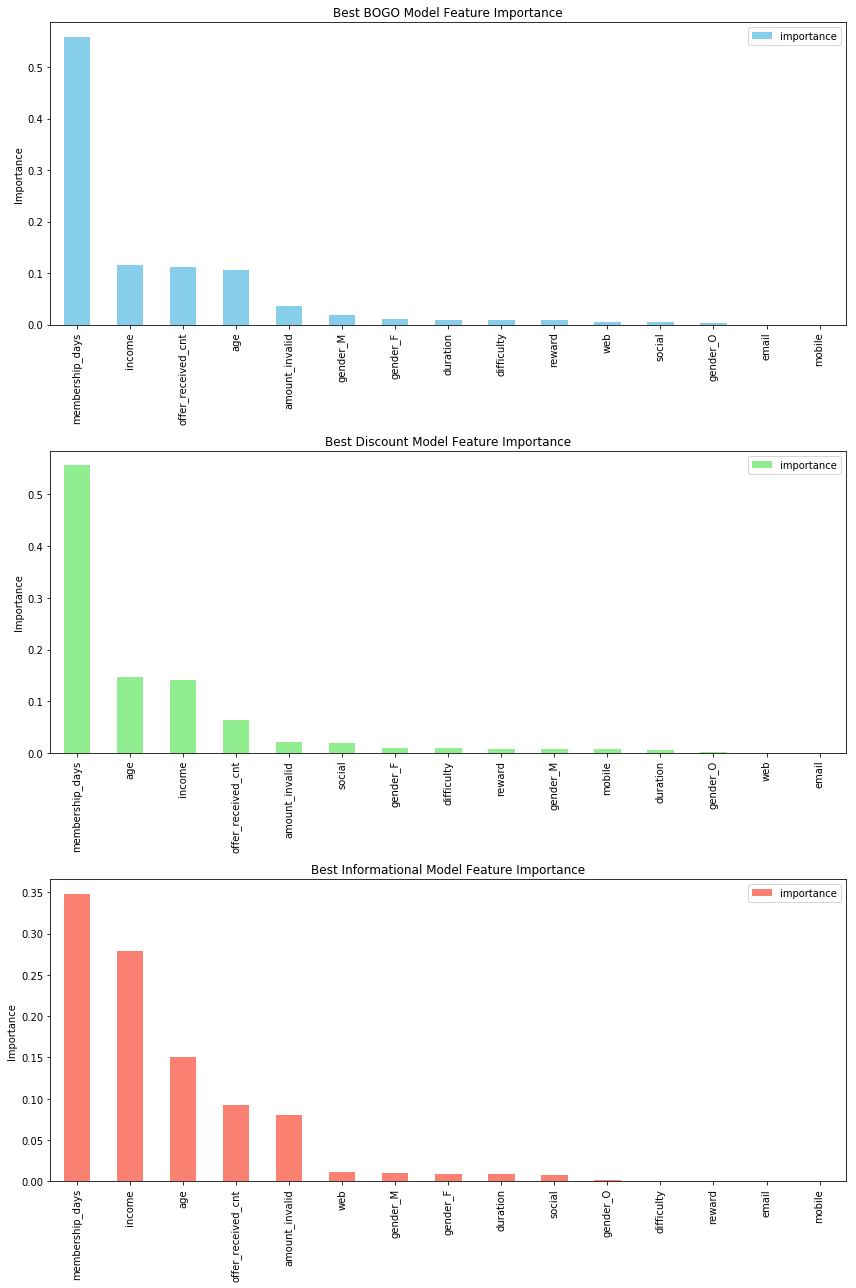

In [77]:
# Analyze importance of features for each of the top performing models

# BOGO
features_bogo, target_bogo = model_prep(offers_bogo, offers_cols_dropped)
bogo_feature_importances = pd.DataFrame(bogo_r2.feature_importances_,
                                        index=features_bogo.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)

# Discount
features_discount, target_discount = model_prep(offers_discount, offers_cols_dropped)
discount_feature_importances = pd.DataFrame(discount_r2.feature_importances_,
                                             index=features_discount.columns,
                                             columns=['importance']).sort_values('importance', ascending=False)

# Informational
features_info, target_info = model_prep(offers_info, offers_cols_dropped)
info_feature_importances = pd.DataFrame(informational_r2.feature_importances_,
                                        index=features_info.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)

# Create vertical subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False)

# Plot BOGO feature importance
bogo_feature_importances.plot.bar(ax=axes[0], color='skyblue')
axes[0].set_title('Best BOGO Model Feature Importance')
axes[0].set_ylabel('Importance')
axes[0].tick_params(axis='x', rotation=90)

# Plot Discount feature importance
discount_feature_importances.plot.bar(ax=axes[1], color='lightgreen')
axes[1].set_title('Best Discount Model Feature Importance')
axes[1].set_ylabel('Importance')
axes[1].tick_params(axis='x', rotation=90)

# Plot Informational feature importance
info_feature_importances.plot.bar(ax=axes[2], color='salmon')
axes[2].set_title('Best Informational Model Feature Importance')
axes[2].set_ylabel('Importance')
axes[2].tick_params(axis='x', rotation=90)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Membership tenure is the most influential factor in offer effectiveness across all models, emphasizing the importance of long-term membership in driving positive customer responses. Income ranks as the second most important feature, reflecting its role in offer engagement and overall impact.

In the BOGO model, membership tenure dominates, while income, age, and number of offer received per person contribute minimally. For the discount model, age and income follow membership tenure but with relatively minor influence.

The informational model shows a more balanced feature distribution, with income as the second key factor, followed by age and number of offer received per person. The latter’s significant highlights the role of communication platforms in shaping responses to informational offers regarding to web channel, compared to other offer types.

Now, I create histogram for each of offer types based on top 3 influenced factors which are membership days, income and age

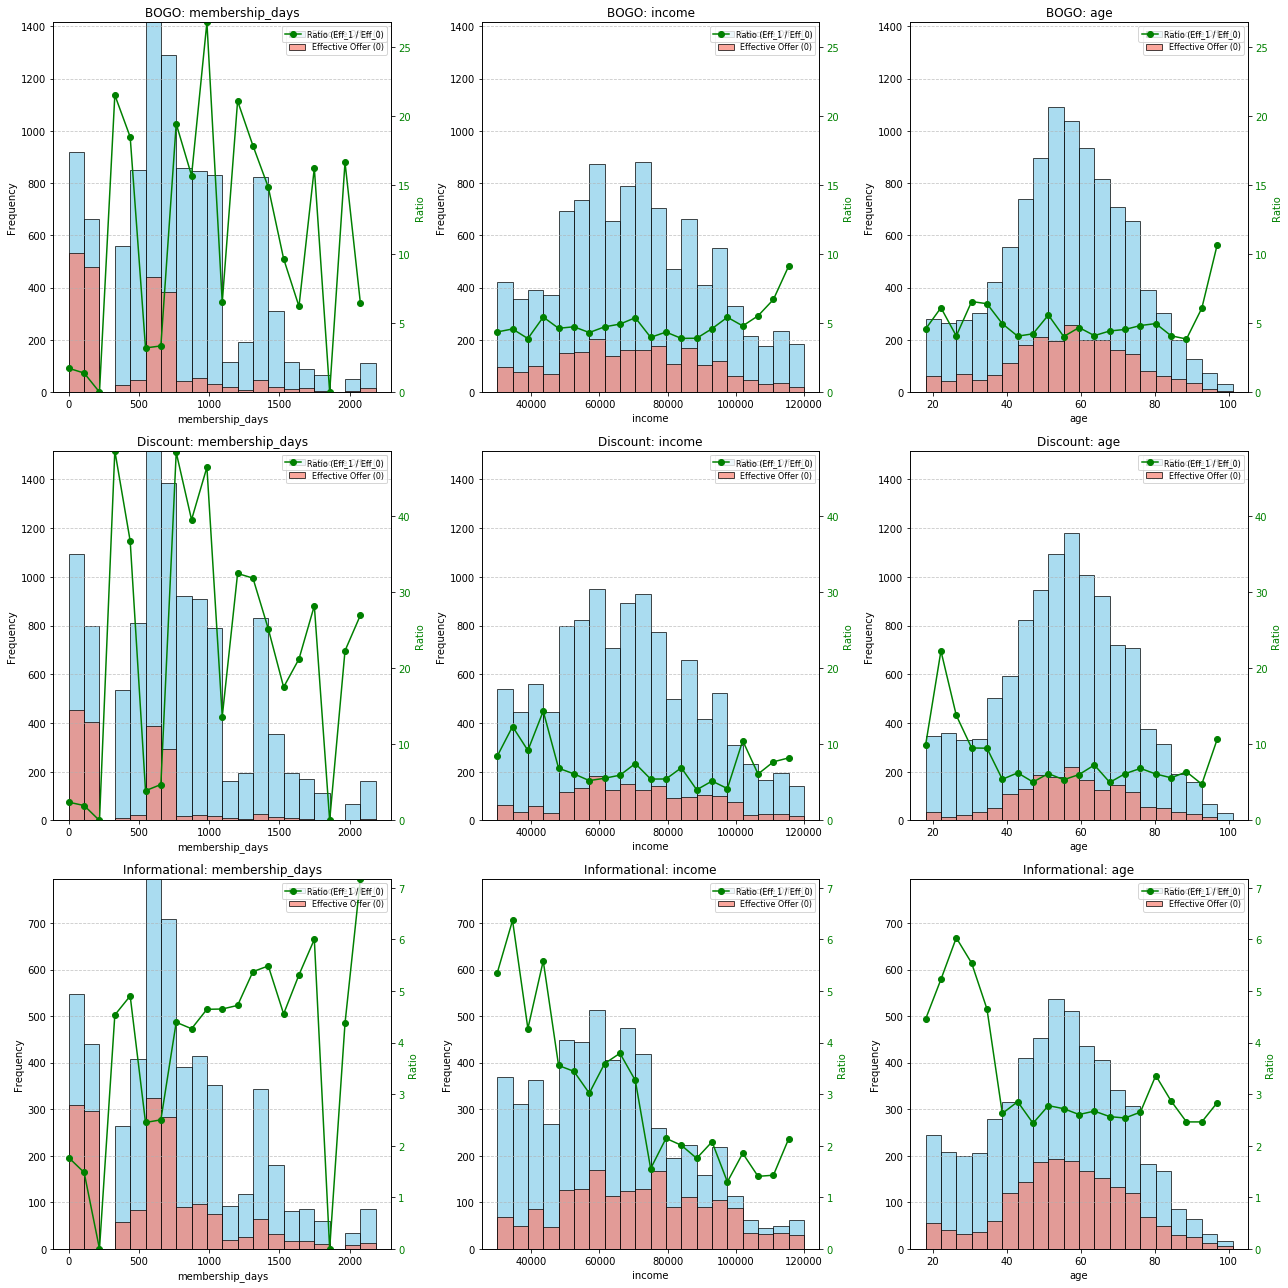

In [78]:
# Define a helper function to create histograms with ratio lines
def plot_histograms_with_ratio(data, column, ax, title, freq_max, ratio_max):
    # Filter data
    eff_1 = data[data['effective_offer'] == 1][column]
    eff_0 = data[data['effective_offer'] == 0][column]
    
    # Determine bin edges manually
    all_values = np.concatenate((eff_1, eff_0))
    bins = np.linspace(all_values.min(), all_values.max(), 21)  # 20 bins

    # Create histograms
    hist_1, _ = np.histogram(eff_1, bins=bins)
    hist_0, _ = np.histogram(eff_0, bins=bins)

    # Plot histograms on the primary y-axis
    ax.hist(eff_1, bins=bins, alpha=0.7, label='Effective Offer (1)', color='skyblue', edgecolor='black')
    ax.hist(eff_0, bins=bins, alpha=0.7, label='Effective Offer (0)', color='salmon', edgecolor='black')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, freq_max)  # Set uniform scale for frequency

    # Calculate and plot the ratio on the secondary y-axis
    ratio = np.divide(hist_1, hist_0, out=np.zeros_like(hist_1, dtype=float), where=hist_0 > 0)
    ax2 = ax.twinx()
    ax2.plot(bins[:-1], ratio, marker='o', color='green', label='Ratio (Eff_1 / Eff_0)')
    ax2.set_ylabel('Ratio', fontsize=10, color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim(0, ratio_max)  # Set uniform scale for ratio
    ax2.legend(loc='upper right', fontsize=8)

# Define the datasets and columns
datasets = {'BOGO': offers_bogo, 'Discount': offers_discount, 'Informational': offers_info}
columns = ['membership_days', 'income', 'age']

# Calculate global maximum values for frequency and ratio for each offer type
freq_max_dict = {}
ratio_max_dict = {}

for offer_type, data in datasets.items():
    freq_max = 0
    ratio_max = 0
    for column in columns:
        eff_1 = data[data['effective_offer'] == 1][column]
        eff_0 = data[data['effective_offer'] == 0][column]
        bins = np.linspace(np.concatenate((eff_1, eff_0)).min(), np.concatenate((eff_1, eff_0)).max(), 21)
        
        hist_1, _ = np.histogram(eff_1, bins=bins)
        hist_0, _ = np.histogram(eff_0, bins=bins)
        
        freq_max = max(freq_max, hist_1.max(), hist_0.max())
        ratio = np.divide(hist_1, hist_0, out=np.zeros_like(hist_1, dtype=float), where=hist_0 > 0)
        ratio_max = max(ratio_max, ratio.max())
    
    freq_max_dict[offer_type] = freq_max
    ratio_max_dict[offer_type] = ratio_max

# Create subplots for the 9 plots
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharey=False)

# Plot histograms with uniform scales
for row_idx, (offer_type, data) in enumerate(datasets.items()):
    for col_idx, column in enumerate(columns):
        plot_histograms_with_ratio(
            data, 
            column, 
            axes[row_idx, col_idx], 
            f'{offer_type}: {column}', 
            freq_max_dict[offer_type], 
            ratio_max_dict[offer_type]
        )

# Adjust layout and show plot
plt.tight_layout()
plt.show()


The histograms of each offer type based on 3 most influenced continuous factors gave an overview look on which bins imposed higher converted rate than other. It was noticeable that ineffective offers were extremely high with short membership periods, and for those users maintaining membership for over 500 days (especially 500-1,000 days) the effective offers rate peaked with subtantial rate over the ineffective offers (with weight gaining from number of offers). 

The pattern for income and age were quite similar between 3 offer types but for informational offers, income factors showed significant influence for income range under 50,000 for successful conversion rate compared age range under 40, which coincided with significant of income influence improved in information offers.

## 6. Conclusion

**Question 1:** Membership tenure was the strongest predictor of offer effectiveness across all three models, followed by income and age, with their importance varying slightly by offer type. In BOGO and discount offers, feature importance was relatively consistent, whereas informational offers showed a more balanced distribution, with income as the second most significant factor.

**Question 2:** Using separate models for each offer type yielded strong results, with high accuracy for BOGO (82.95%) and discount (86.4%) models, and acceptable accuracy for informational offers (76.47%). The lower accuracy is reasonable since informational offers have no associated costs.

Accuracy above 80% for BOGO and discount models is satisfactory for business use, as revenue gains from correctly targeted offers can outweigh occasional misclassifications. Further analysis can be implemented to examine the high rate of ineffective offers for short membership period and successful converion rate peak on range of 500-1,000 days of membership, as well as higher influence of income for range under 50,000 to conversion rate for informational offers.


### Main challenges & potential improvements

Several challenges and insights emerged when I run through the project:

1. Model Attribution: Defining a model for conversion events was the most difficult task. Users were divided into four groups based on their actions, but assigning users in Group 3 using transactional data was particularly challenging. Establishing the event space to link offer ids to transactions was crucial.

2. Feature Engineering: Identifying and engineering key features was critical for model success. Membership tenure proved to be the most significant predictor of offer effectiveness.

3. Model Implementation: Separate models for BOGO, discount, and informational offers reduced noise and improved accuracy. BOGO and discount models performed well, while the informational model had slightly lower accuracy due to limited data.

Tree-based models were chosen to evaluate feature importance, but exploring parametric or regression models could provide valuable insights by comparing coefficient weights with tree-based feature importance.

In [79]:
# Extract html
from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_notebook.ipynb'])

0